In [1]:
# import useful packages.
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch  # Pytorch
import torch.nn as nn  # Neural network module
import torch.nn.functional as fn  # Function module
from torchvision import datasets  # Datasets from torchvision
import matplotlib.pyplot as plt  # Plotting using matplotlib
from livelossplot import PlotLosses
from sklearn.model_selection import StratifiedShuffleSplit

import torch.autograd as autograd
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torchvision.datasets import DatasetFolder, ImageFolder
from PIL import Image
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
from PIL import Image
import torch
import os
import cv2
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn as nn
import csv
from livelossplot import PlotLosses
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
import random
from torchvision import models

# Task1: Resnet18 Model

## 1. Loading data (a single storm)

In [2]:
# load the local file as a dataset
folder_path = "all_storm_image/"
bkh_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')and f.startswith('fgi')]

bkh_images = []
# Loop through the images and load each one
for image_file in bkh_files:
    image_path = os.path.join(folder_path, image_file)
    img = cv2.imread(image_path)
    bkh_images.append(img)
    

In [3]:
l = len(bkh_images)

In [4]:
bkh_images_0 = np.zeros([l,366,366])
for i in range(l):
    num = int(bkh_files[i][4:7])
    bkh_images_0[num] = bkh_images[i][:,:,0]/255 * 2 -1


In [5]:
data0 = torch.Tensor(bkh_images_0[:-1])
next0 = torch.Tensor(bkh_images_0[1:])
# Create a TensorDataset
data = TensorDataset(data0, next0)

In [6]:
# Define the split ratio (e.g., 80% train, 20% test)
train_ratio = 0.8

# Calculate the split sizes
train_size = int(train_ratio * len(data))
val_size = len(data) - train_size

train_set, val_set = torch.utils.data.random_split(
    list(zip(data0, next0)),
    [train_size, val_size]
)

In [7]:
# Define batch size
bs = 10

# create DataLoader
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_set, batch_size=bs ,shuffle=False)

Batch size: 10
Number of batches: 20
Num images: 200
Image shape: torch.Size([10, 366, 366])
Next shape: torch.Size([10, 366, 366])
Num pixels: 133956
Range: max, 0.8980392217636108 min,-0.9764705896377563


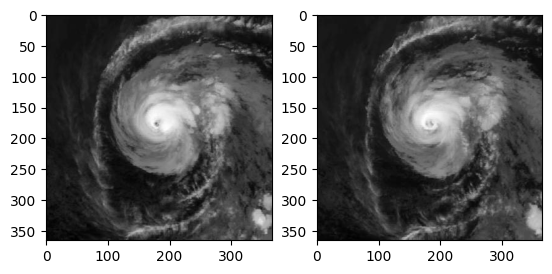

In [8]:
print(train_loader)
print('Batch size: '+str(train_loader.batch_size))
print('Number of batches: '+str(train_loader.__len__()))  # Check the number of batches
print('Num images: '+str(train_loader.batch_size*train_loader.__len__()))

images, nexts = next(iter(train_loader))  # Get the first batch of images

print('Image shape: '+str(images.shape))
print('Next shape: '+str(nexts.shape))
fig, axs = plt.subplots(1, 2)
axs[0].imshow(images[0].squeeze(), cmap='gray')  # Plot the first image in the batch
axs[1].imshow(nexts[0].squeeze(), cmap='gray')  # Plot the first image in the batch
print('Num pixels: '+str(images.shape[1]*images.shape[2]))  # How many pixels are in the image
print('Range: max, '+str(float(images.max()))+' min,'+str(float(images.min())))

In [9]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
     

No GPU available!


## 2. Resize the figure with MaxPool2d

Image shape: torch.Size([10, 366, 366])
Next shape: torch.Size([10, 91, 91])
Num pixels: 133956
Range: max, 1.0 min,-1.0
torch.Size([10, 91, 91])


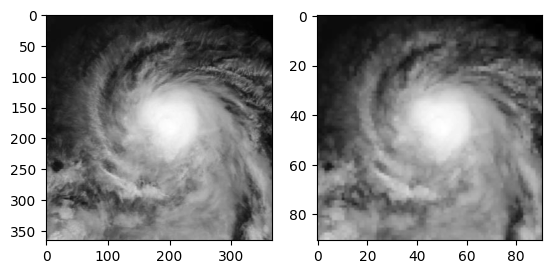

In [10]:
import torch
import torch.nn as nn

class MaxPoolCNN(nn.Module):
    def __init__(self):
        super(MaxPoolCNN, self).__init__()
        
        # Assuming the input is a single-channel image (e.g., grayscale)
        # First Max Pooling Layer: kernel size 2, stride 2 (halves the dimensions)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second Max Pooling Layer: kernel size 2, stride 2 (halves the dimensions again)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third Max Pooling Layer: kernel size 2, stride 2
        #self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        


    def forward(self, x):
        x = self.pool1(x)
        x = self.pool2(x)
        #x = self.pool3(x)

        # After the pooling layers, the dimensions will be reduced
        return x

# Initialize the model
model = MaxPoolCNN()

# Create a dummy input tensor of shape [batch_size, channels, height, width]
images, nexts = next(iter(train_loader))  # Get the first batch of images
input_tensor = images

# Forward pass through the model
output_tensor = model(input_tensor)

print('Image shape: '+str(images.shape))
print('Next shape: '+str(output_tensor.shape))
fig, axs = plt.subplots(1, 2)
axs[0].imshow(images[0].squeeze(), cmap='gray')  # Plot the first image in the batch
axs[1].imshow(output_tensor[0].squeeze(), cmap='gray')  # Plot the first image in the batch
print('Num pixels: '+str(images.shape[1]*images.shape[2]))  # How many pixels are in the image
print('Range: max, '+str(float(images.max()))+' min,'+str(float(images.min())))


# Print the shape of the output tensor
print(output_tensor.shape)


## 3. Setting up Neural Network

In [11]:
# Basic Block for ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [12]:
# ResNet-18 architecture for 32x32 input size
class ResNet18_drop(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet18_drop, self).__init__()
        self.in_channels = 64
        # reduce the size
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        #self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))


        self.fc = nn.Linear(512, num_classes)


    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * BasicBlock.expansion
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.pool1(x)
        #x = self.pool2(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        #x = self.dropout(x)
        x = self.fc(x)

        return x


In [13]:
# Instantiate the ResNet-18 model for 32x32 input size
model_drop = ResNet18_drop(num_classes=366*366)  # Change num_classes according to your classification task

# Print the model architecture
print(model_drop)

# Define loss function and optimizer
criterion = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_drop.parameters(), lr=0.001)

ResNet18_drop(
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e

## 4. Model trainning

In [16]:
# the training function
def train(model, data_loader, criterion, optimizer):
    model.train()
    total_loss,total_samples = 0.0, 0
    for data, label in data_loader:
        optimizer.zero_grad()
        output = model(data.view(-1, 1, 366, 366))
        output = output.view(-1,366,366)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_samples += data.shape[0]
    return total_loss / total_samples


# the validate function
def validate(model, data_loader, criterion):
    model.eval()
    total_loss, total_samples = 0.0, 0
    with torch.no_grad():
        for data, label in data_loader:
            output = model(data.view(-1, 1, 366, 366))
            output = output.view(-1,366,366)
            loss = criterion(output, label)
            total_loss += loss.item()
            total_samples += data.shape[0]

    return total_loss / total_samples

# Train the model
train(model_drop, train_loader, criterion, optimizer)

# Validate the model
validate(model_drop, val_loader,criterion)

0.01956830680370331

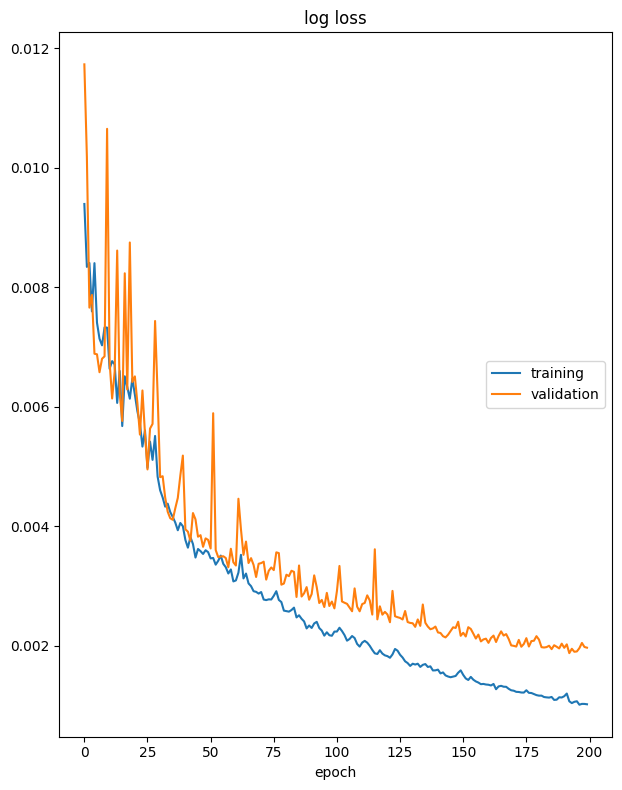

log loss
	training         	 (min:    0.001, max:    0.009, cur:    0.001)
	validation       	 (min:    0.002, max:    0.012, cur:    0.002)


In [17]:
liveloss = PlotLosses()
for i in range(500):
    train_loss = train(model_drop, train_loader, criterion, optimizer)
    valid_loss = validate(model_drop, val_loader,criterion)

    # Liveloss plot
    logs = {}
    logs['' + 'log loss'] = train_loss
    logs['val_' + 'log loss'] = valid_loss

    liveloss.update(logs)
    liveloss.draw()

## 5. Prediction result

loss: 0.010371941
Image shape: torch.Size([10, 366, 366])
Next shape: torch.Size([10, 366, 366])
Range: max, 1.0 min,-1.0
Range: max, 0.7973101139068604 min,-0.9361355304718018
torch.Size([10, 366, 366])


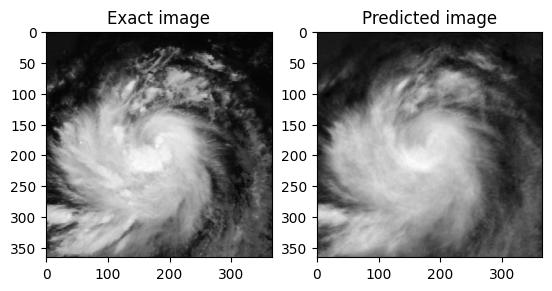

In [ ]:
# Create a dummy input tensor of shape [batch_size, channels, height, width]
images, nexts = next(iter(val_loader))  # Get the first batch of images

i =random.randint(0,len(images)-1)
input_tensor = images
# Forward pass through the model
output_tensor = model_drop(input_tensor.view(-1, 1, 366, 366))
output_tensor = output_tensor.view(-1,366,366)
pred = output_tensor.detach().numpy()[i]
loss = criterion(output_tensor, nexts)
print('loss:', loss.detach().numpy())
print('Image shape: '+str(images.shape))
print('Next shape: '+str(output_tensor.shape))
fig, axs = plt.subplots(1, 2)
axs[0].set(title="Exact image")
axs[0].imshow(nexts[i].squeeze(), cmap='gray')  
axs[1].imshow(pred.squeeze(), cmap='gray')  
axs[1].set(title="Predicted image")
#print('Num pixels: '+str(images.shape[1]*images.shape[2]))  # How many pixels are in the image

print('Range: max, '+str(float(nexts.max()))+' min,'+str(float(nexts.min())))
print('Range: max, '+str(float(pred.max()))+' min,'+str(float(pred.min())))
# Print the shape of the output tensor
print(output_tensor.shape)

In [19]:
torch.save(model_drop,'model_drop.pth')